<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosII/blob/master/notebooks/4c_casoNetflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sistema de recomendación: caso Netflix

Objetivo: construir un sistema de recomendación de películas basado en los datos de Netflix.

Los pasos a seguir son:
* Análisis de datos
* Pre-procesamiento
* Construcción del sistema de recomendación
    - Usando filtrado colaborativo
    - Usando las correlaciones de Pearson

[Créditos y fuente de datos](https://www.kaggle.com/laowingkin/netflix-movie-recommendation)

In [76]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [77]:
path = "~/Desktop/netflix-prize-dataset/"

In [78]:
"""Carga de la base de datos"""
#selección de ID y rating
df = pd.read_csv(path + "combined_data_1.txt", 
                 header = None, names = ['User_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)
print("Tamaño original:", df.shape)

Tamaño original: (24058263, 2)


In [79]:
print(df.columns)
df_raiting = df[:500000] #selección de sub-conjunto de registros
df_raiting.tail(10)

Index(['User_Id', 'Rating'], dtype='object')


,User_Id,Rating
499990,2284938,3.0
499991,996626,4.0
499992,1778262,1.0
499993,1823668,2.0
499994,1129025,4.0
499995,1957556,4.0
499996,1492198,3.0
499997,1018901,3.0
499998,213704,4.0
499999,2143870,3.0


In [80]:
print('Tamaño de la base de datos: {}'.format(df_raiting.shape))

Tamaño de la base de datos: (500000, 2)


## Análisis de datos

In [81]:
print("Conteo de raitings")
p = df_raiting.groupby('Rating')['Rating'].agg(['count'])
print(p)

Conteo de raitings
         count
Rating        
1.0      25316
2.0      52325
3.0     147151
4.0     174248
5.0     100812


In [82]:
movie_count = df_raiting.isnull().sum()[1]#Se obtiene el total de películas
users_count = df_raiting['User_Id'].nunique() - movie_count#Se obtiene el total de usuarios
rating_count = df_raiting['User_Id'].count() - movie_count#Se obtiene el total de ratings

print("Total de películas:", movie_count, "total de usuarios:", users_count, "total de ratings:", rating_count)

Total de películas: 148 total de usuarios: 214992 total de ratings: 499852


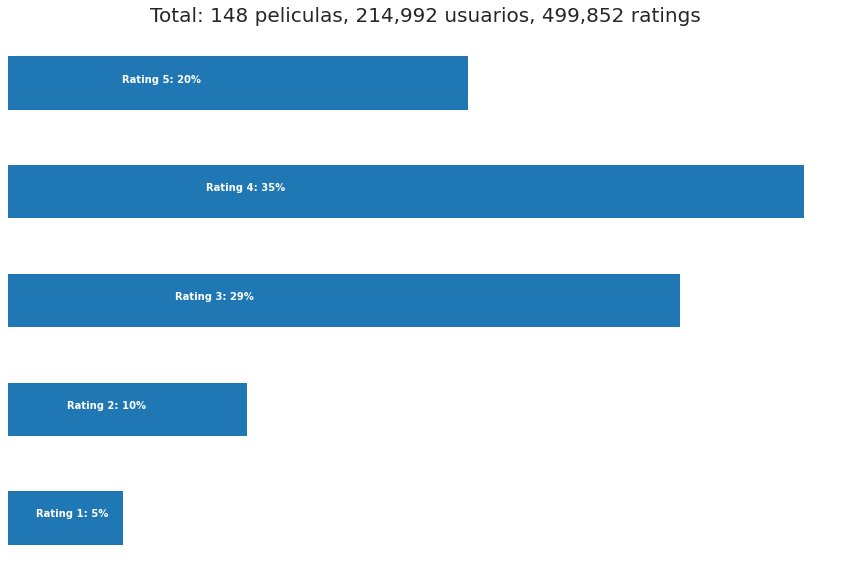

In [83]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total: {:,} peliculas, {:,} usuarios, {:,} ratings'.format(movie_count, users_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Se observa que la mayoría de los ratings tiende a ser positiva (>3)

## Pre-procesamiento

In [84]:
"""Crear una matriz para el ID de la película (procesamiento más eficiente)"""
df_nan = pd.DataFrame(pd.isnull(df_raiting.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

print("Tamaño df_nan:", df_nan.shape)
df_nan.head(10)

Tamaño df_nan: (148, 2)


,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
5,3991,True
6,5011,True
7,5105,True
8,20016,True
9,20112,True


In [85]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id) #Return a new array of given shape and type, filled with movie_id
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [86]:
# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df_raiting) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record) #indices de las películas

print('Películas (numpy): {}'.format(movie_np))

Películas (numpy): [  1.   1.   1. ... 148. 148. 148.]


In [87]:
"""Visualizamos nuevamente"""
df_raiting = df_raiting[pd.notnull(df_raiting['Rating'])]

df_raiting['Movie_Id'] = movie_np.astype(int)
df_raiting['User_Id'] = df_raiting['User_Id'].astype(int)
df_raiting

,User_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
499995,1957556,4.0,148
499996,1492198,3.0,148
499997,1018901,3.0,148
499998,213704,4.0,148


## Selección de usuarios y películas

Algunos criterios que se toman en cuenta:

- Eliminar películas con menos ratings (relativamente no son populares)
- Eliminar a los usuarios que dieron menos reseñas (son relativamente menos activos)

In [88]:
f = ['count','mean']
df_movie_summary = df_raiting.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Películas menos populares: {}'.format(movie_benchmark))

df_cust_summary = df_raiting.groupby('User_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Usuarios menos activos: {}'.format(cust_benchmark))

Películas menos populares: 1205.0
Usuarios menos activos: 2.0


In [89]:
"""Después de reducir la base de datos, vemos cómo queda"""
print('Tamaño original: {}'.format(df_raiting.shape))
df_raiting = df_raiting[~df_raiting['Movie_Id'].isin(drop_movie_list)]
df_raiting = df_raiting[~df_raiting['User_Id'].isin(drop_cust_list)]
print('Tamaño después de la reducción: {}'.format(df_raiting.shape))

Tamaño original: (499852, 3)
Tamaño después de la reducción: (364216, 3)


In [90]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/netflix_new_ratings.csv')
df.to_csv(path + "netflix_new_ratings.csv")

## Carga del catálogo de películas

In [91]:
"""Carga de la base de datos de películas"""
df_movies = pd.read_csv(path + "movie_titles.csv", 
                        encoding = "ISO-8859-1", header = None, 
                        names = ['Movie_Id', 'Year', 'Name'])
df_movies.set_index('Movie_Id', inplace = True)
print (df_movies.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [92]:
#Esta dataframe, lo reservaremos para generar las recomendaciones
movies = df_movies.copy() #hacemos una copia de df_movies
movies = movies.reset_index()
movies = movies[~movies['Movie_Id'].isin(drop_movie_list)]

## Construcción del sistema de recomendación usando filtrado colaborativo

Usamos la biblioteca [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html) y se emplea el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).

In [93]:
"""Entrenar el modelo"""
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader()
data = Dataset.load_from_df(df_raiting[['User_Id', 'Movie_Id', 'Rating']], reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25)
svd = SVD() #definición del modelo
trainset = data.build_full_trainset()
svd.fit(trainset) #training

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

Rendimiento sobre conjunto de prueba
RMSE: 0.7195
0.7194884210855614


In [94]:
#Lista testset
testset[:10]

[(2028581, 30, 4.0),
 (1413163, 46, 2.0),
 (1716556, 30, 5.0),
 (1516387, 118, 2.0),
 (669124, 110, 4.0),
 (327075, 143, 4.0),
 (754397, 111, 4.0),
 (1077666, 104, 5.0),
 (1848936, 78, 4.0),
 (2513094, 143, 3.0)]

In [95]:
""" Analicemos a un usuario en particular """
#user_id de un usuario específico
userid= 988097 
user = df_raiting[(df_raiting['User_Id'] == userid) & (df_raiting['Rating'] == 5)]
user = user.set_index('Movie_Id')
user = user.join(df_movies)['Name']
print("Películas que ha visto el usuario "+str(userid))
print(user)

Películas que ha visto el usuario 988097
Movie_Id
118    Rambo: First Blood Part II
Name: Name, dtype: object


In [96]:
movies['Estimate_Score'] = movies['Movie_Id'].apply(lambda x: svd.predict(userid, x).est)
movies = movies.sort_values('Estimate_Score', ascending=False)
movies.head(10)

,Movie_Id,Year,Name,Estimate_Score
67,68,2004.0,Invader Zim,4.869740
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,4.377046
75,76,1952.0,I Love Lucy: Season 2,4.331103
46,47,1952.0,The Bad and the Beautiful,4.287220
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.275417
112,113,2000.0,Bruce Lee: A Warrior's Journey,4.252551
24,25,1997.0,Inspector Morse 31: Death Is Now My Neighbour,4.195884
51,52,2002.0,The Weather Underground,4.141365
43,44,1996.0,Spitfire Grill,4.116185
45,46,1964.0,Rudolph the Red-Nosed Reindeer,4.080009


## Ejercicio

1. Ejecuta la libreta actual y obtenen la predición para un par de usuarios diferentes
- Previamente (descarga la libreta actual y los datos de Kaggle)

2. Aumenta el número de registros a analizar.
  - Vuelve a ejecutar la libreta y genera las recomendaciones para los dos usuarios previos y genera dos nuevas predicciones (nuevos usuarios)


### Ejercicio 1

In [97]:
def get_movies_from(user_id, rating_gt, df_raiting):
    user = df_raiting[(df_raiting['User_Id'] == user_id) & (df_raiting['Rating'] >= rating_gt)]
    user = user.set_index('Movie_Id')
    return user.join(df_movies)['Name']

def predict_for(user_id, num_movies, svd, movies):
    movies['Estimate_Score'] = movies['Movie_Id'].apply(lambda x: svd.predict(user_id, x).est)
    movies = movies.sort_values('Estimate_Score', ascending=False)
    return movies.head(num_movies)

def movie_prediction(user_id, num_movies, rating_gt, movies, df_raiting, svd):
    print(f"User id: {user_id}")
    print(get_movies_from(user_id, rating_gt, df_raiting))
    return predict_for(user_id, num_movies, svd, movies)

In [104]:
user_id_1 = df_raiting["User_Id"].sample(n=1, random_state=1).values[0]
user_id_2 = df_raiting["User_Id"].sample(n=1, random_state=1).values[0]

num_movies = 10
rating_gt = 4

print(user_id_1, user_id_2)

1527206 1527206


In [105]:
movie_prediction(user_id_1, num_movies, rating_gt, movies, df_raiting, svd)

User id: 1527206
Movie_Id
30         Something's Gotta Give
175                Reservoir Dogs
191              X2: X-Men United
215      That '70s Show: Season 1
269                    Parenthood
270    Sex and the City: Season 4
299         Bridget Jones's Diary
Name: Name, dtype: object


,Movie_Id,Year,Name,Estimate_Score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.287295
67,68,2004.0,Invader Zim,3.874652
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,3.674186
137,138,1995.0,Star Trek: Voyager: Season 1,3.610547
43,44,1996.0,Spitfire Grill,3.462510
45,46,1964.0,Rudolph the Red-Nosed Reindeer,3.427608
78,79,1956.0,The Killing,3.394631
29,30,2003.0,Something's Gotta Give,3.387761
112,113,2000.0,Bruce Lee: A Warrior's Journey,3.368654
103,104,1965.0,The Great Race,3.329077


In [106]:
movie_prediction(user_id_2, num_movies, rating_gt, movies, df_raiting, svd)

User id: 1527206
Movie_Id
30         Something's Gotta Give
175                Reservoir Dogs
191              X2: X-Men United
215      That '70s Show: Season 1
269                    Parenthood
270    Sex and the City: Season 4
299         Bridget Jones's Diary
Name: Name, dtype: object


,Movie_Id,Year,Name,Estimate_Score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.287295
67,68,2004.0,Invader Zim,3.874652
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,3.674186
137,138,1995.0,Star Trek: Voyager: Season 1,3.610547
43,44,1996.0,Spitfire Grill,3.462510
45,46,1964.0,Rudolph the Red-Nosed Reindeer,3.427608
78,79,1956.0,The Killing,3.394631
29,30,2003.0,Something's Gotta Give,3.387761
112,113,2000.0,Bruce Lee: A Warrior's Journey,3.368654
103,104,1965.0,The Great Race,3.329077


### Ejercicio 2

In [101]:
df_raiting = df[:500000*3]
"""Crear una matriz para el ID de la película (procesamiento más eficiente)"""
df_nan = pd.DataFrame(pd.isnull(df_raiting.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id) #Return a new array of given shape and type, filled with movie_id
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df_raiting) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record) #indices de las películas

"""Visualizamos nuevamente"""
df_raiting = df_raiting[pd.notnull(df_raiting['Rating'])]

df_raiting['Movie_Id'] = movie_np.astype(int)
df_raiting['User_Id'] = df_raiting['User_Id'].astype(int)

"""Después de reducir la base de datos, vemos cómo queda"""
df_raiting = df_raiting[~df_raiting['Movie_Id'].isin(drop_movie_list)]
df_raiting = df_raiting[~df_raiting['User_Id'].isin(drop_cust_list)]


"""Entrenar el modelo"""

reader = Reader()
data = Dataset.load_from_df(df_raiting[['User_Id', 'Movie_Id', 'Rating']], reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25)
svd2 = SVD() #definición del modelo
trainset = data.build_full_trainset()
svd2.fit(trainset) #training

In [109]:
movie_prediction(user_id_1, num_movies, rating_gt, movies, df_raiting, svd)

User id: 1527206
Movie_Id
30         Something's Gotta Give
175                Reservoir Dogs
191              X2: X-Men United
215      That '70s Show: Season 1
269                    Parenthood
270    Sex and the City: Season 4
299         Bridget Jones's Diary
Name: Name, dtype: object


,Movie_Id,Year,Name,Estimate_Score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.287295
67,68,2004.0,Invader Zim,3.874652
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,3.674186
137,138,1995.0,Star Trek: Voyager: Season 1,3.610547
43,44,1996.0,Spitfire Grill,3.462510
45,46,1964.0,Rudolph the Red-Nosed Reindeer,3.427608
78,79,1956.0,The Killing,3.394631
29,30,2003.0,Something's Gotta Give,3.387761
112,113,2000.0,Bruce Lee: A Warrior's Journey,3.368654
103,104,1965.0,The Great Race,3.329077


In [110]:
movie_prediction(user_id_1, num_movies, rating_gt, movies, df_raiting, svd2)

User id: 1527206
Movie_Id
30         Something's Gotta Give
175                Reservoir Dogs
191              X2: X-Men United
215      That '70s Show: Season 1
269                    Parenthood
270    Sex and the City: Season 4
299         Bridget Jones's Diary
Name: Name, dtype: object


,Movie_Id,Year,Name,Estimate_Score
132,133,2003.0,Viva La Bam: Season 1,4.485386
269,270,2001.0,Sex and the City: Season 4,4.473794
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,4.316253
214,215,1998.0,That '70s Show: Season 1,4.133312
75,76,1952.0,I Love Lucy: Season 2,4.030418
228,229,2003.0,Peter Gabriel: Growing Up Live,4.014793
240,241,1959.0,North by Northwest,3.991362
67,68,2004.0,Invader Zim,3.957210
160,161,1939.0,Ninotchka,3.952972
241,242,1995.0,Neon Genesis Evangelion: The End of Evangelion,3.909384
